# Humanaoid Standup Project

Enviroment Setup and imports

In [1]:
!pip install gymnasium[mujoco]
import gymnasium as gym
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.distributions import Normal
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt
from tqdm import tqdm

# device setup
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

from google.colab import drive
drive.mount('/content/drive')

# enviroment

env = gym.make('HumanoidStandup-v5', max_episode_steps=100)
obs, info = env.reset()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.5/243.5 kB 10.2 MB/s eta 0:00:00
Mounted at /content/drive


In [25]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Memory

In [3]:
class Memory():
  def __init__(self, batch_size):
    self.states = []
    self.values = []
    self.actions = []
    self.probs = []
    self.rewards = []
    self.finished = []
    self.batch_size = batch_size

  def store_transition_data(self, state, value, a, prob, reward, finished):
    self.states.append(state)
    if torch.is_tensor(value):
      value = value.detach().squeeze().item()
    self.values.append(value)

    if torch.is_tensor(a):
      a = a.detach().cpu().squeeze(0)
    self.actions.append(a)

    if torch.is_tensor(prob):
      prob = prob.detach().cpu().squeeze().item()
    self.probs.append(prob)

    self.rewards.append(reward)
    self.finished.append(finished)

  def create_batches(self):
    states = torch.tensor(np.array(self.states), dtype = torch.float32).to(device)
    values = torch.tensor(self.values, dtype = torch.float32).to(device)
    actions = torch.tensor(np.array(self.actions), dtype = torch.float32).to(device)
    probs = torch.tensor(self.probs, dtype = torch.float32).to(device)
    rewards = torch.tensor(self.rewards, dtype = torch.float32).to(device)
    finished = torch.tensor(self.finished, dtype = torch.bool).to(device)

    random_indices = np.random.permutation(len(states))
    batch_starting_indices = np.arange(0,len(states), self.batch_size)
    batches = []

    for b in batch_starting_indices:
      batches.append(random_indices[b:b+self.batch_size])

    return states, values, actions, probs, rewards, finished, batches

  def restart_memory(self):
    self.states = []
    self.values = []
    self.actions = []
    self.probs = []
    self.rewards = []
    self.finished = []

###Actor

In [4]:
class Actor(nn.Module):
  def __init__(self, observation_dim, action_dim, hidden_size = 256, layers=2, nonlinearity=nn.ReLU):
    super().__init__()

    self.actor = nn.Sequential()

    self.actor.add_module("Lin0", nn.Linear(observation_dim, hidden_size))
    self.actor.add_module("Nonlin0", nonlinearity())
    for i in range(layers-1):
      self.actor.add_module(f"Lin{i+1}", nn.Linear(hidden_size, hidden_size))
      self.actor.add_module(f"Nonlin{i+1}", nonlinearity())

    self.actor.add_module(f"Lin{layers+1}", nn.Linear(hidden_size, action_dim))

    self.std_logged = nn.Parameter(torch.zeros(action_dim)) # trainable std parameter

  def forward(self,observation):
    mean = self.actor(observation)
    std = torch.exp(self.std_logged)
    return mean, std

  def compute_distr(self, observation):
    mean, std = self.forward(observation)
    distr = torch.distributions.Normal(mean, std)
    return distr

  def take_action(self, observation):
    distr = self.compute_distr(observation)
    action_sampled = distr.sample()
    log_probabilty  = distr.log_prob(action_sampled).sum(dim= -1)
    return action_sampled, log_probabilty

###Critic

In [5]:
class Critic(nn.Module):
  def __init__(self, observation_dim, hidden_size = 256, layers=2, nonlinearity=nn.ReLU):
    super().__init__()

    self.critic = nn.Sequential()

    self.critic.add_module("Lin0", nn.Linear(observation_dim, hidden_size))
    self.critic.add_module("Nonlin0", nonlinearity())
    for i in range(layers-1):
      self.critic.add_module(f"Lin{i+1}", nn.Linear(hidden_size, hidden_size))
      self.critic.add_module(f"Nonlin{i+1}", nonlinearity())

    self.critic.add_module(f"Lin{layers+1}", nn.Linear(hidden_size, 1))


  def forward(self, observation):
    return self.critic(observation)

### Interacting Agent

In [ ]:
class PPOController:
  def __init__(self,observation_dim, action_dim, lambda_, gamma, alpha,  clip, N, epochs, batch_size, hidden_size, layers, nonlinearity=nn.ReLU):
    self.observation_dim = observation_dim
    self.controller_memory = Memory(batch_size)
    self.action_dim = action_dim
    self.lambda_ = lambda_
    self.gamma = gamma
    self.alpha = alpha
    self.clip = clip
    self.N = N
    self.epochs = epochs
    self.batch_size = batch_size
    self.actor = Actor(observation_dim, action_dim, hidden_size=hidden_size, layers=layers, nonlinearity=nonlinearity).to(device)
    self.critic = Critic(observation_dim, hidden_size=hidden_size, layers=layers, nonlinearity=nonlinearity).to(device)
    self.actor_opt = torch.optim.Adam(self.actor.parameters(), lr = alpha)
    self.critic_opt = torch.optim.Adam(self.critic.parameters(), lr = alpha)

  def sample_action(self,observation):
    observation_torch = torch.as_tensor(observation, dtype = torch.float32).to(device)
    if observation_torch.dim() == 1:
      observation_torch = observation_torch.unsqueeze(0) # add batch dim
    action_sampled, log_probabilty = self.actor.take_action(observation_torch)
    state_value = self.critic(observation_torch)
    return action_sampled, log_probabilty, state_value


  def compute_gae(self):
    states, values, actions, prev_probs, rewards, finished, batches  = self.controller_memory.create_batches()
    add_one = torch.zeros(1, dtype = values.dtype).to(device)
    vals = torch.cat([values, add_one], dim = 0)
    advantages = torch.zeros_like(rewards).to(device)
    prev_advantage = 0
    T = len(rewards)

    # computes gae (reversed)
    for t in reversed(range(T)):
      finished_mask = 1 - finished[t].float()
      td_error  = rewards[t] + self.gamma * vals[t+1] *finished_mask - vals[t]
      advantage = td_error + self.gamma * self.lambda_ * prev_advantage * finished_mask
      prev_advantage = advantage
      advantages[t]  = advantage

    return states, values, actions, prev_probs, rewards, finished, batches, advantages


  def iterate_batches(self):
    states, values, actions, prev_probs, rewards, finished, batches, advantages = self.compute_gae()
    batch_loss = []
    for batch in batches:
      batch_states = states[batch]
      batch_actions = actions[batch]
      batch_prev_probs = prev_probs[batch]
      batch_advantages = advantages[batch]
      batch_rewards = rewards[batch]
      batch_values = values[batch]

      distribution = self.actor.compute_distr(batch_states)
      new_log_probabilty = distribution.log_prob(batch_actions).sum(dim = -1)
      prob_ratio = (new_log_probabilty - batch_prev_probs).exp()

      value_pred = self.critic(batch_states).squeeze(-1)

      # computing actor loss
      term1 = prob_ratio * batch_advantages
      term2 = torch.clamp(prob_ratio, 1-self.clip, 1+ self.clip)*batch_advantages
      actor_loss =  -torch.min(term1, term2).mean()

      # computing critic loss
      return_ = batch_advantages + batch_values
      critic_loss = 0.5 * ((value_pred - return_)**2).mean()

      total_loss = actor_loss + critic_loss
      batch_loss.append(total_loss)

    batch_loss = torch.stack(batch_loss).mean()

    return batch_loss


  def train(self):
    for ep in range(self.epochs):
      total_loss = self.iterate_batches()
      self.actor_opt.zero_grad()
      self.critic_opt.zero_grad()
      total_loss.backward()
      self.actor_opt.step()
      self.critic_opt.step()
    self.controller_memory.restart_memory()


# Running

### PPO Agent Training Loop

In [ ]:
from gymnasium.wrappers import TimeLimit

def train_ppo_agent(PPOAgent, runs=1000, N=2048):
  done = False
  scores = []
  mean_score = 0.0
  top_score = float('-inf')
  steps = 0
  mean_scores_list = []

  for i in tqdm(range(runs)):
    observation, info = env.reset()

    score = 0
    done = False
    while done == False:
      action, log_prob, val = PPOAgent.sample_action(observation)

      a = action.squeeze(0).detach().cpu().numpy()
      obs, r, terminated, truncated, info = env.step(a)
      done = terminated or truncated
      steps += 1

      PPOAgent.controller_memory.store_transition_data(observation, val, action, log_prob, r, done)
      if steps % N == 0:
        PPOAgent.train()
      score += r
      observation = obs

    scores.append(score)
    mean_score = np.mean(scores[-100:]) # prev 100 runs
    mean_scores_list.append(mean_score)

    if mean_score > top_score:
      top_score = mean_score

  return scores, mean_scores_list, top_score

In [ ]:
# parameters
hidden_size = 256
observation_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
alpha = 3e-4
batch_size = 64
gamma = 0.9
lambda_ = 0.95
clip = 0.2
epochs = 4
N = 2048
nonlinearity = nn.ReLU


PPOAgent = PPOController(observation_dim, action_dim, lambda_, gamma, alpha,  clip, N, epochs, batch_size, hidden_size, nonlinearity)
scores, mean_scores_list = train_ppo_agent(PPOAgent)

  #print(f'EP: {i}, BEST SCORE: {top_score}, AVG 50: {mean_score}')

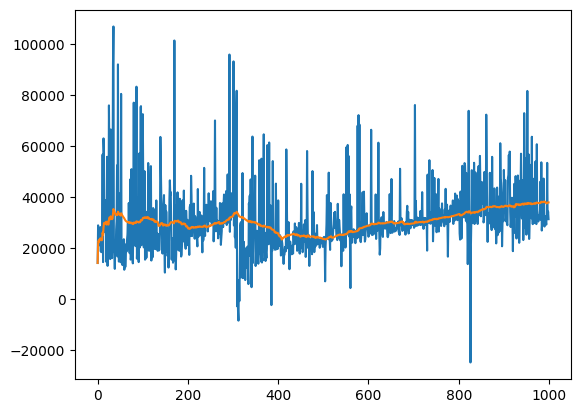

In [ ]:
import matplotlib.pyplot as plt
plt.plot(scores)
plt.plot(mean_scores_list)
plt.show()

###Saving models/data

In [ ]:
torch.save(PPOAgent, "PPOAgent.pth")
np.save('Scores.npy',np.array(scores))
np.save('MeanScores.npy',np.array(mean_scores_list))

# Hyperparameter Tuning

#### Architecture Experimentation

##### Experimentation with Nonlinearities

In [ ]:
hidden_size = 256
observation_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
alpha = 3e-4
batch_size = 64
gamma = 0.9
lambda_ = 0.95
clip = 0.2
epochs = 4
N = 2048

nonlinearities = [nn.ReLU, nn.Tanh, nn.SiLU]

nonlinearity_scores = []
nonlinearity_means = []

for i in range(3):
  PPOAgent = PPOController(observation_dim, action_dim, lambda_, gamma, alpha,  clip, N, epochs, batch_size, hidden_size, nonlinearities[i])
  scores, mean_scores_list, top_score = train_ppo_agent(PPOAgent, runs=2000)

  nonlinearity_scores.append(scores)
  nonlinearity_means.append(mean_scores_list)



100%|██████████| 2000/2000 [1:44:49<00:00,  3.14s/it]


In [ ]:
for i in range(3):
  np.save(f'Scores{i}.npy',np.array(nonlinearity_scores[i]))
  np.save(f'MeanScores{i}.npy',np.array(nonlinearity_means[i]))

In [27]:
nonlinearity_scores = []
nonlinearity_means = []

for i in range(3):
  nonlinearity_scores.append(np.load(f'/content/drive/MyDrive/CMPE260Data/NonlinearitiesData/Scores{i}.npy'))
  nonlinearity_means.append(np.load(f'/content/drive/MyDrive/CMPE260Data/NonlinearitiesData/MeanScores{i}.npy'))

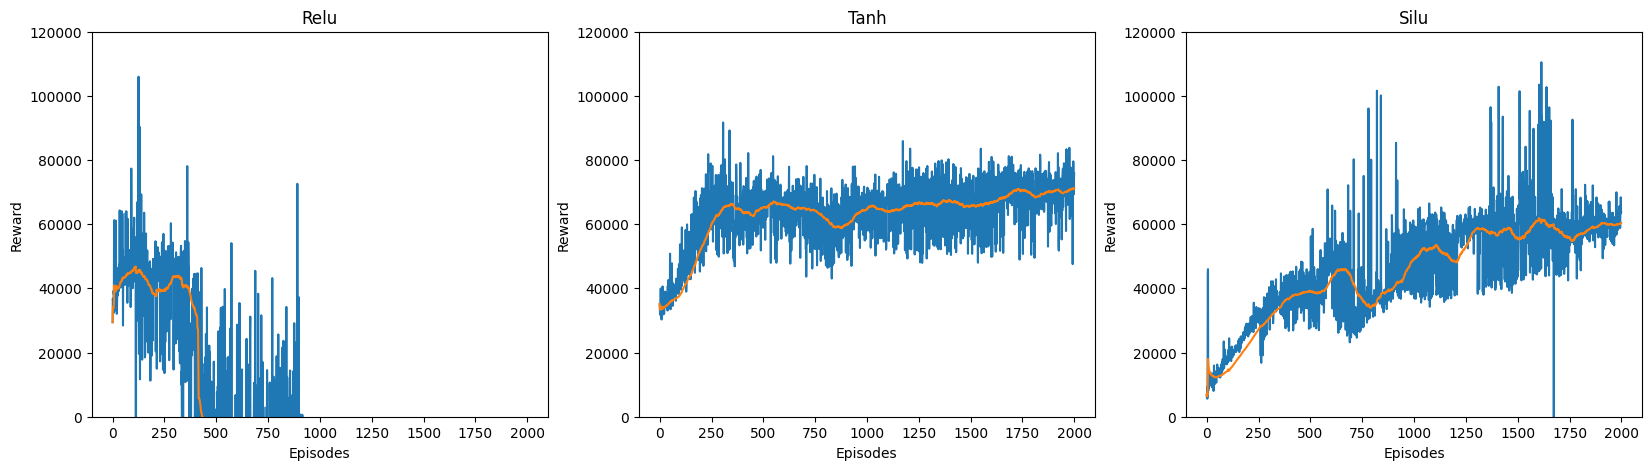

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(20,5))

nonlinearity_labels = ["Relu", "Tanh", "Silu"]

for i in range(3):
  axes[i].plot(nonlinearity_scores[i])
  axes[i].plot(nonlinearity_means[i])
  axes[i].set_ylim(0, 120000)

  axes[i].set_title(nonlinearity_labels[i])
  axes[i].set_xlabel("Episodes")
  axes[i].set_ylabel("Reward")




Relu seemed to be less stable compared to other nonlinearities.

Tanh quickly learns and stabilizes around 70k reward average.


Silu learns more slowly but more smoothly.

##### Experimentation with model width and depth

In [ ]:
hidden_size = 256
observation_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
alpha = 3e-4
batch_size = 64
gamma = 0.9
lambda_ = 0.95
clip = 0.2
epochs = 4
N = 2048

nonlinearity = nn.Tanh # performed best with prior experiements

model_hidden_depth_list = [2, 3]
model_hidden_width_list = [128, 256, 512]

model_complexity_scores_data = []
model_complexity_mean_scores_data = []

for i in range(2):
  for j in range(3):
    layers = model_hidden_depth_list[i]
    hidden_size = model_hidden_width_list[j]

    PPOAgent = PPOController(observation_dim, action_dim, lambda_, gamma, alpha,  clip, N, epochs, batch_size, hidden_size, layers, nonlinearity)
    scores, mean_scores_list, top_score = train_ppo_agent(PPOAgent, runs=2000)

    model_complexity_scores_data.append(scores)
    model_complexity_mean_scores_data.append(mean_scores_list)

    torch.save(PPOAgent, f"/content/drive/MyDrive/CMPE260Data/HiddenLayerSizeData/PPOAgent{i}{j}.pth")
    np.save(f'/content/drive/MyDrive/CMPE260Data/HiddenLayerSizeData/Scores{i}{j}.npy',np.array(scores))
    np.save(f'/content/drive/MyDrive/CMPE260Data/HiddenLayerSizeData/MeanScores{i} {j}.npy',np.array(mean_scores_list))



100%|██████████| 2000/2000 [1:36:16<00:00,  2.89s/it]


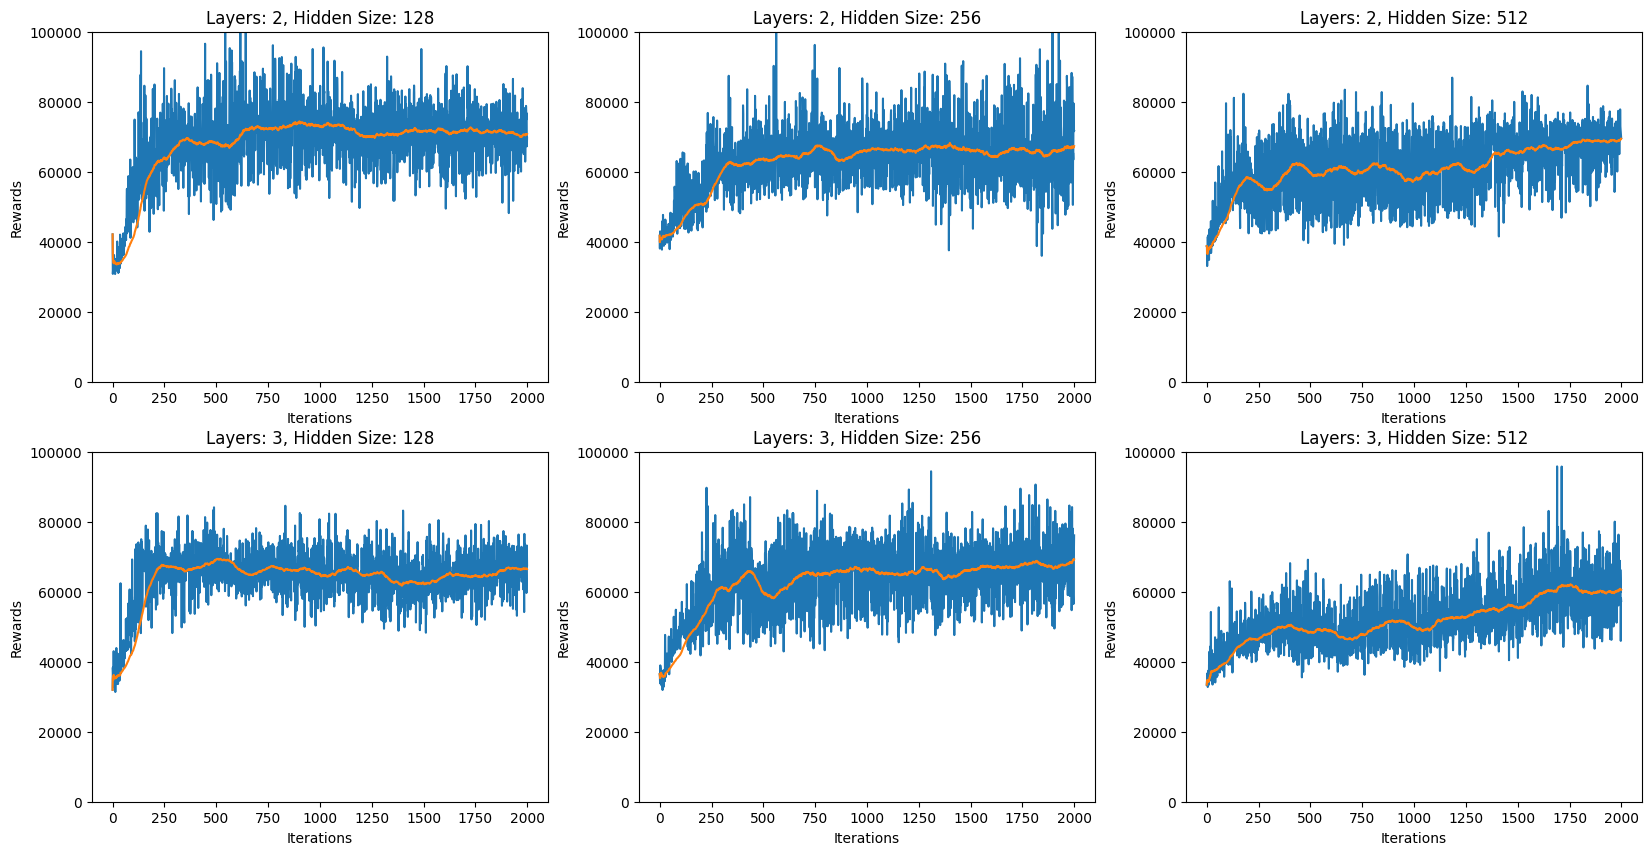

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(20,10))

for i in range(2):
  for j in range(3):
    axes[i][j].plot(model_complexity_scores_data[3*i+j])
    axes[i][j].plot(model_complexity_mean_scores_data[3*i+j])
    axes[i][j].set_ylim(0, 100000)
    axes[i][j].set_title(f"Layers: {model_hidden_depth_list[i]}, Hidden Size: {model_hidden_width_list[j]}")
    axes[i][j].set_xlabel("Iterations")
    axes[i][j].set_ylabel("Rewards")

Since many of the larger models have similar performance, I continued using the simpler model with 2 layers and a hidden size of 256.

## Finetuning Hyperparameters with Optuna

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 12.3 MB/s eta 0:00:00


In [ ]:
def training_step_ppo_agent(PPOAgent, scores, mean_scores_list, top_score, runs=1000, N=2048):
  done = False
  steps = 0
  mean_score = 0.0

  for i in range(runs):
    observation, info = env.reset()
    score = 0
    done = False
    while done == False:
      action, log_prob, val = PPOAgent.sample_action(observation)

      a = action.squeeze(0).detach().cpu().numpy()
      obs, r, terminated, truncated, info = env.step(a)
      done = terminated or truncated
      steps += 1

      PPOAgent.controller_memory.store_transition_data(observation, val, action, log_prob, r, done)
      if steps % N == 0:
        PPOAgent.train()
      score += r
      observation = obs

    scores.append(score)
    mean_score = np.mean(scores[-100:]) # prev 100 runs
    mean_scores_list.append(mean_score)

    if mean_score > top_score:
      top_score = mean_score

  return

I tuned only 4 parameters due to the high amount of compute needed to train for this task: learning_rate, clip range, discount factor, and number of epochs per data batch.

In [ ]:
# Referenced article: https://medium.com/data-and-beyond/master-the-power-of-optuna-a-step-by-step-guide-ed43500e9b95
import optuna

def objective(trial):
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
  clip = trial.suggest_float("clip", 0.1, 0.3)
  discount_factor = trial.suggest_categorical("discount_factor", [0.9, 0.95, 0.99])
  epochs = trial.suggest_int("epochs", 4, 6)



  observation_dim = env.observation_space.shape[0]
  action_dim = env.action_space.shape[0]
  alpha = learning_rate
  batch_size = 64
  gamma = discount_factor
  lambda_ = 0.95
  N = 2048

  layers = 2
  hidden_size = 256

  nonlinearity = nn.Tanh



  PPOAgent = PPOController(observation_dim, action_dim, lambda_, gamma, alpha,  clip, N, epochs, batch_size, hidden_size, layers, nonlinearity)

  trial_scores = []
  trial_mean_scores = []
  top_score = float('-inf')

  for i in tqdm(range(30)):
    training_step_ppo_agent(PPOAgent, trial_scores, trial_mean_scores, top_score, runs=50)

    trial.report(trial_mean_scores[-1], step=i)

    if trial.should_prune():
        raise optuna.TrialPruned()

  np.save(f'/content/drive/MyDrive/CMPE260Data/OptunaTrialsData/Scores{trial.number}.npy', trial_scores)
  np.save(f'/content/drive/MyDrive/CMPE260Data/OptunaTrialsData/MeanScores{trial.number}.npy', trial_mean_scores)

  return trial_mean_scores[-1]






In [ ]:
pruner = optuna.pruners.MedianPruner(
    n_startup_trials=2,
    n_warmup_steps=2
)

study = optuna.create_study(direction="maximize", pruner=pruner, storage="sqlite:////content/drive/MyDrive/CMPE260Data/optuna_study.db", load_if_exists=True)

study.optimize(objective, n_trials=15)

[I 2025-11-25 02:55:10,814] A new study created in RDB with name: no-name-8f6ddab7-1d3b-4b6d-83d7-dca10f078b3e
/tmp/ipython-input-3174452773.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
100%|██████████| 30/30 [1:10:21<00:00, 140.72s/it]
[I 2025-11-25 04:05:32,639] Trial 0 finished with value: 57261.58512953219 and parameters: {'learning_rate': 0.00047446901189288196, 'clip': 0.24492852375191507, 'discount_factor': 0.95, 'epochs': 4}. Best is trial 0 with value: 57261.58512953219.
100%|██████████| 30/30 [1:17:29<00:00, 154.98s/it]
[I 2025-11-25 05:23:02,104] Trial 1 finished with value: 54119.04994778951 and parameters: {'learning_rate': 0.0005996863811068341, 'clip': 0.26720193809362397, 'discount_factor': 0.9, 'epochs': 6}. Best is trial 0 with value:

In [ ]:
import optuna

summaries = optuna.study.get_all_study_summaries(storage="sqlite:////content/drive/MyDrive/CMPE260Data/optuna_study.db")
for s in summaries:
  print (s.study_name)

no-name-8f6ddab7-1d3b-4b6d-83d7-dca10f078b3e


In [ ]:
study = optuna.load_study(study_name="no-name-8f6ddab7-1d3b-4b6d-83d7-dca10f078b3e", storage="sqlite:////content/drive/MyDrive/CMPE260Data/optuna_study.db")

In [ ]:
print(f"Total trials so far: {len(study.trials)}")

Total trials so far: 23


In [ ]:
study.optimize(objective, n_trials=3)

/tmp/ipython-input-466815580.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
 13%|█▎        | 4/30 [12:52<1:23:39, 193.08s/it]
[I 2025-11-25 22:16:26,431] Trial 15 pruned. 
/tmp/ipython-input-466815580.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
  0%|          | 0/30 [02:15<?, ?it/s]
[I 2025-11-25 22:18:41,610] Trial 16 pruned. 
 20%|██        | 6/30 [17:05<1:08:21, 170.90s/it]
[I 2025-11-25 22:35:47,107] Trial 17 pruned. 


In [ ]:
study.optimize(objective, n_trials=5)

/tmp/ipython-input-466815580.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
  0%|          | 0/30 [02:14<?, ?it/s]
[I 2025-11-25 22:40:37,129] Trial 18 pruned. 
  7%|▋         | 2/30 [07:39<1:47:06, 229.53s/it]
[I 2025-11-25 22:48:16,297] Trial 19 pruned. 
  0%|          | 0/30 [02:23<?, ?it/s]
[I 2025-11-25 22:50:39,790] Trial 20 pruned. 
  7%|▋         | 2/30 [06:49<1:35:36, 204.86s/it]
[I 2025-11-25 22:57:29,642] Trial 21 pruned. 
100%|██████████| 30/30 [1:09:03<00:00, 138.12s/it]
[I 2025-11-26 00:06:33,278] Trial 22 finished with value: 84716.1159438232 and parameters: {'learning_rate': 0.00015131048259794724, 'clip': 0.21778633100389533, 'discount_factor': 0.99, 'epochs': 4}. Best is trial 22 with value: 84716.1159438232.


In [ ]:
study.optimize(objective, n_trials=30)

/tmp/ipython-input-466815580.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
 17%|█▋        | 5/30 [13:44<1:08:41, 164.85s/it]
[I 2025-11-26 09:20:00,749] Trial 23 pruned. 
/tmp/ipython-input-466815580.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
100%|██████████| 30/30 [1:08:18<00:00, 136.61s/it]
[I 2025-11-26 10:28:19,246] Trial 24 finished with value: 69530.21803729297 and parameters: {'learning_rate': 0.0003482490586585272, 'clip': 0.22715341973187902, 'discount_factor': 0.99, 'epochs': 4}. Best is trial 22 with value:

In [ ]:
import optuna
study = optuna.load_study(study_name="no-name-8f6ddab7-1d3b-4b6d-83d7-dca10f078b3e", storage="sqlite:////content/drive/MyDrive/CMPE260Data/optuna_study.db")

In [ ]:
print(study.best_params)

{'learning_rate': 0.00015131048259794724, 'clip': 0.21778633100389533, 'discount_factor': 0.99, 'epochs': 4}


## Further Exploration of model parameters

In [ ]:
hidden_size = 256
layers = 2

observation_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

alpha = 1.5e-4
batch_size = 64
gamma = 0.99
lambda_ = 0.95
clip = 0.218
epochs = 4
N = 2048

nonlinearity = nn.Tanh

FinalPPOAgent = PPOController(observation_dim, action_dim, lambda_, gamma, alpha,  clip, N, epochs, batch_size, hidden_size, layers, nonlinearity)

final_scores, final_mean_scores, final_top_score = train_ppo_agent(FinalPPOAgent, 15000)

torch.save(FinalPPOAgent, f"/content/drive/MyDrive/CMPE260Data/FinalPPO.pth")
np.save(f'/content/drive/MyDrive/CMPE260Data/FinalPPOScores.npy',np.array(final_scores))
np.save(f'/content/drive/MyDrive/CMPE260Data/FinalPPOMeanScores.npy',np.array(final_mean_scores))


100%|██████████| 15000/15000 [9:49:17<00:00,  2.36s/it]


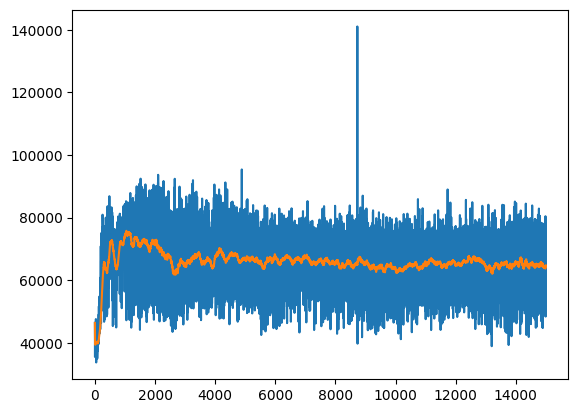

In [ ]:
plt.plot(final_scores)
plt.plot(final_mean_scores)
plt.show()

In [ ]:
hidden_size = 256
layers = 2

observation_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

alpha = 1.5e-4
batch_size = 64
gamma = 0.99
lambda_ = 0.95
clip = 0.218
epochs = 4
N = 2048

nonlinearity = nn.SiLU # Experimenting with the nonlinearity that learned more smoothly

FinalPPOAgent = PPOController(observation_dim, action_dim, lambda_, gamma, alpha,  clip, N, epochs, batch_size, hidden_size, layers, nonlinearity)

final_scores, final_mean_scores, final_top_score = train_ppo_agent(FinalPPOAgent, 10000)

torch.save(FinalPPOAgent, f"/content/drive/MyDrive/CMPE260Data/FinalPPO2.pth")
np.save(f'/content/drive/MyDrive/CMPE260Data/FinalPPOScores2.npy',np.array(final_scores))
np.save(f'/content/drive/MyDrive/CMPE260Data/FinalPPOMeanScores2.npy',np.array(final_mean_scores))


100%|██████████| 10000/10000 [9:12:06<00:00,  3.31s/it]


In [ ]:
hidden_size = 256
layers = 2

observation_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

alpha = 1.5e-4
batch_size = 64
gamma = 0.995
lambda_ = 0.95
clip = 0.218
epochs = 4
N = 2048

nonlinearity = nn.SiLU

FinalPPOAgent = PPOController(observation_dim, action_dim, lambda_, gamma, alpha,  clip, N, epochs, batch_size, hidden_size, layers, nonlinearity)

final_scores, final_mean_scores, final_top_score = train_ppo_agent(FinalPPOAgent, 50000)

torch.save(FinalPPOAgent, f"/content/drive/MyDrive/CMPE260Data/FinalPPO3.pth")
np.save(f'/content/drive/MyDrive/CMPE260Data/FinalPPOScores3.npy',np.array(final_scores))
np.save(f'/content/drive/MyDrive/CMPE260Data/FinalPPOMeanScores3.npy',np.array(final_mean_scores))


100%|██████████| 50000/50000 [3:48:59<00:00,  3.64it/s]


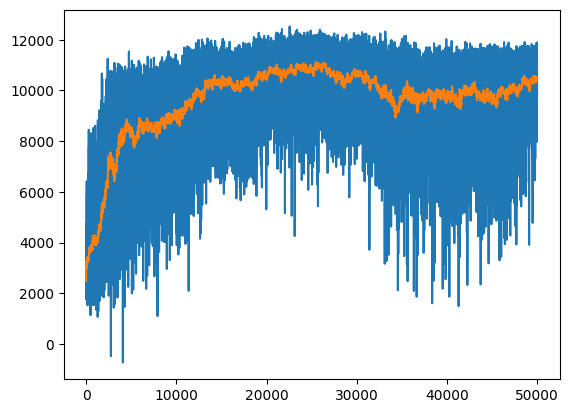

In [ ]:
plt.plot(final_scores)
plt.plot(final_mean_scores)
plt.show()